<span style="font-size:10pt">Copyright Jean-Luc CHARLES $-$ 2025/03/14 $-$ CC BY-SA 4.0 $-$  <img src="img/CC-BY-SA.jpeg" width="50"></span> 

# Training Reproducibility with tensorflow

<div class="alert alert-block alert-danger">
<span style="color:brown;font-family:arial;font-size:normal"> 
    It is fundamental to use a <span style="font-weight:bold;">Python Virtual Environment</span> (PVE) for each important Python project: the PVE makes it possible to control for each project the versions of the Python interpreter and "sensitive" modules (like tensorflow for example).</span></div>

Notebook tested with tensorflow 2.16.2

## 1 - Import the required Python modules

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #suppress the numerous TensorFlow warnings

import tensorflow as tf
from tensorflow import keras

import sys
import matplotlib.pyplot as plt
import numpy as np
import cv2
from time import time
from cpuinfo import get_cpu_info

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# specific modules:
from utils.tools import scan_dir, plot_images, plot_loss_accuracy, elapsed_time_since, show_conf_matrix, plot_proportion_bar

print(f"Python    : {sys.version.split()[0]}")
print(f"tensorflow: {tf.__version__} with keras {keras.__version__}")
print(f"numpy     : {np.__version__}")
print(f"OpenCV    : {cv2.__version__}")

Python    : 3.12.3
tensorflow: 2.16.2 with keras 3.9.0
numpy     : 1.26.4
OpenCV    : 4.11.0


In [2]:
# allows to visualize the graphs directly in the cell of the notebook:
%matplotlib inline

Unless explicitly stated, we use this seed value to make reproducible the random generators:

In [3]:
SEED = 1234

## 2 - Load the MNIST dataset (images and labels)

We use the keras `load_data` function to load the data from the MNIST 
(see [tf.keras.datasets.mnist.load_data](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/mnist/load_data)):<br>
- `im_train`, `lab_train` are the training images and labels,
- `im_valid`, `lab_valid` are the validation images and labels.

In [4]:
(im_train, lab_train), (im_valid, lab_valid) = keras.datasets.mnist.load_data()

Let's check the `shape` and `dtype` attributes of the numpy arrays:

In [5]:
print(f"im_train.shape:  {im_train.shape}, dtype: {im_train.dtype}")
print(f"im_valid.shape:  {im_valid.shape}, dtype: {im_valid.dtype}")
print(f"lab_train.shape: {lab_train.shape}, dtype: {lab_train.dtype}")
print(f"lab_vaild.shape: {lab_valid.shape}, dtype: {lab_valid.dtype}")

im_train.shape:  (60000, 28, 28), dtype: uint8
im_valid.shape:  (10000, 28, 28), dtype: uint8
lab_train.shape: (60000,), dtype: uint8
lab_vaild.shape: (10000,), dtype: uint8


### Reduce the size of the dataset

The MNIST datset has a hudge number of images : 60000. For demonstration purpose, we will truncate the input arrays to 1/10 of the initial sizes. 

In [6]:
im_train  = im_train[:6000]
lab_train = lab_train[:6000]
im_valid  = im_valid[:1000]
lab_valid = lab_valid[:1000]

print("im_train.shape :", im_train.shape, ", lab_train.shape:", lab_train.shape)
print("im_valid.shape :", im_valid.shape, ", lab_valid.shape:", lab_valid.shape)

im_train.shape : (6000, 28, 28) , lab_train.shape: (6000,)
im_valid.shape : (1000, 28, 28) , lab_valid.shape: (1000,)


### Visualization of images and labels:

The local module `utils.tools` defines the `plot_images` function which can be used to display a grid of MNIST images.<br>
Let's plot a grid of images 3 x 10 beginning with the 600th image:

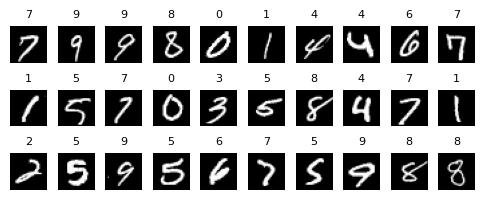

In [7]:
plot_images(im_train, 3, 10, 599, label_array=lab_train)

### Create the 3 datasets: train, validation & test

To follow the _state of the art_, we will split the dataset into train, validation & test datasets.<br>
A simple way to do this is to keep the train dataset and to split the current validation dataset in two equal subsets:
- a new smaller validation subset,
- a new test subset.

In [8]:
# note on train_test_split : Stratified train/test split is not implemented for shuffle=False 
# We give the seed value with the 'random_state' parameter to ensure a reproducible splitting.

im_valid, im_test, lab_valid, lab_test = train_test_split(im_valid, lab_valid,
                                                          stratify=lab_valid,
                                                          test_size=0.5,
                                                          shuffle=True,
                                                          random_state=SEED)

We can verify that the proportion of digits remains homogenous in the new datasets:

In [9]:
prop = {}
prop['valid'] = [(lab_valid == i).sum() for i in range(10)]
prop['test']  = [(lab_test  == i).sum() for i in range(10)]

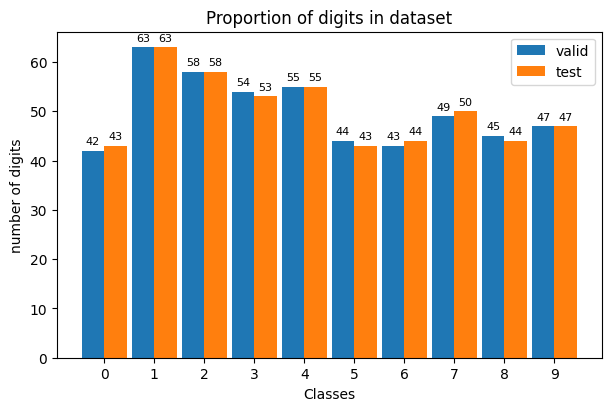

In [10]:
plot_proportion_bar(prop, range(10))

## 3 - Pre-processing the input datasets

### Reshape the data arrays to fit keras requirements

The convolutional layers of **keras** take by default arrays of shape `(batch_size, height, width, depth)` :
- `batch_size` : number of images in a batch of input data,
- `height` et `width` : the size of the images in pixels,
- `depth` : image color dimension (`3` for a RGB image, `1` for a grey tone image).

The current shapes of the input arrays ares :

In [11]:
im_train.shape, im_valid.shape, im_test.shape

((6000, 28, 28), (500, 28, 28), (500, 28, 28))

We must add the dimension `depth` (value: 1 for grey tone images) after the third dimension `width`, for example using the method `reshape` of the class `ndarray`.<br>
We also normalize the input arrays so that their elements are in [0, 1]. 

In [12]:
x_train = im_train.reshape(im_train.shape + (1,))/255
x_valid = im_valid.reshape(im_valid.shape + (1,))/255
x_test  = im_test.reshape(im_test.shape + (1,))/255

# check:
print(f'train:  {im_train.shape} -> {x_train.shape},  min: {x_train.min()}, max: {x_train.max()}')
print(f'valid:  {im_valid.shape} -> {x_valid.shape},  min: {x_valid.min()}, max: {x_valid.max()}')
print(f'test :  {im_test.shape}  -> {x_test.shape},  min: {x_test.min()}, max: {x_test.max()}')

train:  (6000, 28, 28) -> (6000, 28, 28, 1),  min: 0.0, max: 1.0
valid:  (500, 28, 28) -> (500, 28, 28, 1),  min: 0.0, max: 1.0
test :  (500, 28, 28)  -> (500, 28, 28, 1),  min: 0.0, max: 1.0


### *one-hot* encoding of the label arrays:

We use the **keras** `to_categorical` function (see [tf.keras.utils.to_categorical](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical)) to define the `y_train`, `y_valid` and `y_test`, the arrays containing the *hot-one* encoded version of `lab_train`, `lab_valid` and `lab_test`:

In [13]:
from tensorflow.keras.utils import to_categorical
# 'one-hot' encoding' of labels :
y_train = to_categorical(lab_train)
y_valid = to_categorical(lab_valid)
y_test  = to_categorical(lab_test)

Let's check the first 10 values of the `lab_train` and `y_train` arrays:

In [14]:
print(lab_train[:10])
print(y_train[:10])

[5 0 4 1 9 2 1 3 1 4]
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


### Setting useful parameters:

To avoid hard-coding the number of images in the 3 datasets as well as the image size, these parameters are recovered from the data set:
- with the 'shape' attribute of the image arrays
- with the 'size' attribute of the first training image for example.

In [15]:
# number of images in the 3 sets:
NB_IM_TRAIN = im_train.shape[0]
NB_IM_VALID = im_valid.shape[0]     
NB_IM_TEST  = im_test.shape[0]     

# number of classes:
NB_CLASS = len(set(lab_train))

# image shape:
IM_SHAPE = x_train[0].shape

# check:
print(f'{NB_IM_TRAIN=}, {NB_IM_VALID=}, {NB_IM_TEST=}')
print(f"{NB_CLASS} different classes found in the `lab_train` ndarray")
print(f"Image size: {IM_SHAPE}")

NB_IM_TRAIN=6000, NB_IM_VALID=500, NB_IM_TEST=500
10 different classes found in the `lab_train` ndarray
Image size: (28, 28, 1)


## 4 - Build the Convolutional Neural Network (CNN)

We build a CNN similar to __LeNet5__ introduced in the research paper “Gradient-Based Learning Applied To Document Recognition” in 1998 by Yann LeCun, Leon Bottou, Yoshua Bengio, and Patrick Haffnerfrom.

![img/LeNet5.png](img/LeNet5.png)

In the rest of this notebook, we will build the CNN many times so we define the function `build_CNN`:

In [16]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, AveragePooling2D, MaxPool2D, Flatten

def build_CNN(input_shape, seed=None):

    if seed != None:
        # Deterministic tensorflow training: 
        # 1/ set the seed of the random generators involved with tensorflow:
        tf.keras.utils.set_random_seed(seed)
        # 2/ make the tf aps determinisctic 
        # [see https://blog.tensorflow.org/2022/05/whats-new-in-tensorflow-29.html]
        tf.config.experimental.enable_op_determinism()         
    
    model = Sequential(name='LeNet5')
    
    # A layer to give the 4 dimensions of the input data:
    model.add(Input(shape=input_shape))
    
    # Layer C1: 6 convolution filters of 5x5 with padding and 'relu' activation function:
    model.add(Conv2D(6, kernel_size=(5,5), strides=(1,1), padding='same', activation='tanh', name='C1'))
    
    # Layer S2: 'maximum' poolling stage, with 2x2:
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2), padding='valid', name='S2'))
    
    # Layer C3: 16 convolution filters of 5x5 with padding and 'relu' activation function:
    model.add(Conv2D(16, kernel_size=(5,5), strides=(1,1), padding='valid', activation='tanh', name='C3'))
    
    # Layer S4: 'maximum' poolling stage, with 2x2:
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2), padding='valid', name='S4'))
    
    # Flatten the images into a single vector with all the pixels:
    model.add(Flatten())

    # Layer C5: dense layer with 120 neurons and 'relu' activation function:
    model.add(Dense(120, activation='tanh', name='C5'))
    
    # F6: dense layer with 84 neurones and 'relu' activation function:
    model.add(Dense(84, activation='tanh', name='F6'))
    
    # Output: final dense layer, with 'NB_CLASS'(10) neutones and the 'softmax' 
    # activation function dedicated to classification training:
    model.add(Dense(NB_CLASS, activation='softmax', name='Output'))    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

Let's look at the model summary:

In [17]:
model = build_CNN(IM_SHAPE)
model.summary()

Model: "LeNet5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ C1 (Conv2D)                     │ (None, 28, 28, 6)      │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ S2 (MaxPooling2D)               │ (None, 14, 14, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ C3 (Conv2D)                     │ (None, 10, 10, 16)     │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ S4 (MaxPooling2D)               │ (None, 5, 5, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ C5 (Dense)                      │ (None, 120)            │        48,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ F6 (Dense)                      │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 10)             │           850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,706 (241.04 KB)

 Trainable params: 61,706 (241.04 KB)

 Non-trainable params: 0 (0.00 B)

## 5 - Elementary tests of the reproducibility of the CNN training...

In the cell bellow, we train the network on only 1 epoch 5 times on a row:

#### A/ If we don't set the tensorflow seed to build the model at each iteration, the training is not reproducible:

In [18]:
print(get_cpu_info()['brand_raw'])
for _ in range(5):
    model = build_CNN(IM_SHAPE)  # Build a new model with NO SEED GIVEN
    hist = model.fit(x_train, y_train, epochs=1, batch_size=32, validation_data=(x_valid, y_valid), verbose=2)    

Intel(R) Xeon(R) W-1390P @ 3.50GHz
188/188 - 1s - 6ms/step - accuracy: 0.8417 - loss: 0.5505 - val_accuracy: 0.9280 - val_loss: 0.2552
188/188 - 1s - 6ms/step - accuracy: 0.8377 - loss: 0.5829 - val_accuracy: 0.9260 - val_loss: 0.2559
188/188 - 1s - 6ms/step - accuracy: 0.8600 - loss: 0.5112 - val_accuracy: 0.9300 - val_loss: 0.2439
188/188 - 1s - 6ms/step - accuracy: 0.8363 - loss: 0.5704 - val_accuracy: 0.9320 - val_loss: 0.2455
188/188 - 1s - 7ms/step - accuracy: 0.8407 - loss: 0.5788 - val_accuracy: 0.9340 - val_loss: 0.2549


In the previous cell, we must focus on the metrics `val_accuracy`and `val_loss` to evaluate the  training after an epoch: we see that if we repeat 5 times the first epoch of the training, the `val_accuracy`and `val_loss` values differ at each iteration $\leadsto$ the training is not reproducible.

In [19]:
print(get_cpu_info()['brand_raw'])
for _ in range(5):
    model = build_CNN(IM_SHAPE)  # Build a new model without setting seed
    hist = model.fit(x_train, y_train, epochs=1, batch_size=16, validation_data=(x_valid, y_valid), verbose=2)    

Intel(R) Xeon(R) W-1390P @ 3.50GHz
375/375 - 1s - 4ms/step - accuracy: 0.8658 - loss: 0.4555 - val_accuracy: 0.9380 - val_loss: 0.2252
375/375 - 1s - 4ms/step - accuracy: 0.8687 - loss: 0.4478 - val_accuracy: 0.9380 - val_loss: 0.2293
375/375 - 1s - 4ms/step - accuracy: 0.8708 - loss: 0.4463 - val_accuracy: 0.9340 - val_loss: 0.2280
375/375 - 1s - 4ms/step - accuracy: 0.8868 - loss: 0.3971 - val_accuracy: 0.9320 - val_loss: 0.1955
375/375 - 1s - 4ms/step - accuracy: 0.8648 - loss: 0.4705 - val_accuracy: 0.9380 - val_loss: 0.2174


In the celle above, we changed the `batch_size`from 32 to 16 $\leadsto$ the training is still not reproducible.

In [20]:
print(get_cpu_info()['brand_raw'])
for _ in range(5):
    model = build_CNN(IM_SHAPE)  # Build a new model without setting seed
    hist = model.fit(x_train[:1000], y_train[:1000], epochs=1, batch_size=32, 
                     validation_data=(x_valid[:200], y_valid[:200]), verbose=2)    

Intel(R) Xeon(R) W-1390P @ 3.50GHz
32/32 - 1s - 26ms/step - accuracy: 0.5770 - loss: 1.5186 - val_accuracy: 0.7550 - val_loss: 0.9466
32/32 - 1s - 26ms/step - accuracy: 0.5480 - loss: 1.5394 - val_accuracy: 0.7450 - val_loss: 0.8367
32/32 - 1s - 26ms/step - accuracy: 0.5410 - loss: 1.5557 - val_accuracy: 0.7550 - val_loss: 0.8504
32/32 - 1s - 26ms/step - accuracy: 0.5900 - loss: 1.4704 - val_accuracy: 0.7600 - val_loss: 0.8148
32/32 - 1s - 26ms/step - accuracy: 0.5460 - loss: 1.5687 - val_accuracy: 0.7050 - val_loss: 0.9252


In the celle above, we reduce the size of the datsets $\leadsto$ the result is worse.

#### B/ If we just reload the inital network the training is not reproducible:

We save the weights of a model built without setting the seed:

In [21]:
model = build_CNN(IM_SHAPE)
model.save_weights('weights/CNN_noseed.weights.h5')

In [22]:
print(get_cpu_info()['brand_raw'])
model = build_CNN(IM_SHAPE)
for _ in range(5):
    model.load_weights('weights/CNN_tanh_noseed.weights.h5') # reload the inital model weights
    hist = model.fit(x_train, y_train, epochs=1, batch_size=16, validation_data=(x_valid, y_valid), verbose=2)    

Intel(R) Xeon(R) W-1390P @ 3.50GHz
375/375 - 1s - 4ms/step - accuracy: 0.8722 - loss: 0.4523 - val_accuracy: 0.9140 - val_loss: 0.2571


/home/jlc/work/IA-MachineLearning/16-Limoges-IRCEFR/Studies/Reproductibility-MNIST-CNN-GPU/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 22 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


375/375 - 1s - 2ms/step - accuracy: 0.8572 - loss: 0.4719 - val_accuracy: 0.9280 - val_loss: 0.2336
375/375 - 1s - 2ms/step - accuracy: 0.8632 - loss: 0.4663 - val_accuracy: 0.9280 - val_loss: 0.2630
375/375 - 1s - 2ms/step - accuracy: 0.8638 - loss: 0.4657 - val_accuracy: 0.8920 - val_loss: 0.2988
375/375 - 1s - 2ms/step - accuracy: 0.8657 - loss: 0.4659 - val_accuracy: 0.9400 - val_loss: 0.2033


In [23]:
print(get_cpu_info()['brand_raw'])
for _ in range(5):
    model.load_weights('weights/CNN_tanh_noseed.weights.h5') # reload the inital model weights
    hist = model.fit(x_train, y_train, epochs=1, batch_size=32, validation_data=(x_valid, y_valid), verbose=2)    

Intel(R) Xeon(R) W-1390P @ 3.50GHz
188/188 - 1s - 4ms/step - accuracy: 0.8123 - loss: 0.6564 - val_accuracy: 0.8960 - val_loss: 0.3069
188/188 - 0s - 2ms/step - accuracy: 0.8102 - loss: 0.6478 - val_accuracy: 0.9100 - val_loss: 0.3071
188/188 - 0s - 2ms/step - accuracy: 0.8113 - loss: 0.6403 - val_accuracy: 0.9140 - val_loss: 0.2906
188/188 - 0s - 2ms/step - accuracy: 0.8125 - loss: 0.6304 - val_accuracy: 0.8920 - val_loss: 0.3140
188/188 - 0s - 2ms/step - accuracy: 0.8163 - loss: 0.6244 - val_accuracy: 0.9120 - val_loss: 0.2893


The `val_loss` is still non-reproducible.

#### C/ If the tensorflow seed is set fthe training is reproducible:

In [24]:
print(get_cpu_info()['brand_raw'])
for _ in range(5):
    model = build_CNN(IM_SHAPE, seed=1234)
    hist = model.fit(x_train, y_train, epochs=1, batch_size=16, validation_data=(x_valid, y_valid), verbose=2)    

Intel(R) Xeon(R) W-1390P @ 3.50GHz
375/375 - 1s - 4ms/step - accuracy: 0.8610 - loss: 0.4789 - val_accuracy: 0.9320 - val_loss: 0.2211
375/375 - 2s - 4ms/step - accuracy: 0.8610 - loss: 0.4789 - val_accuracy: 0.9320 - val_loss: 0.2211
375/375 - 2s - 5ms/step - accuracy: 0.8610 - loss: 0.4789 - val_accuracy: 0.9320 - val_loss: 0.2211
375/375 - 1s - 4ms/step - accuracy: 0.8610 - loss: 0.4789 - val_accuracy: 0.9320 - val_loss: 0.2211
375/375 - 1s - 4ms/step - accuracy: 0.8610 - loss: 0.4789 - val_accuracy: 0.9320 - val_loss: 0.2211


If we set the seed when creating the model at each iteration the `val_accuracy`and `val_loss` are perfectly reproducible.

#### D/ If we load the model's structure & initial weights at each iteration, the training is reproducible

In [25]:
model = build_CNN(IM_SHAPE, seed=1234)
model.save('models/CNN_tanh_seed1234.keras')

In [26]:
print(get_cpu_info()['brand_raw'])
for _ in range(5):
    model = tf.keras.models.load_model('models/CNN_tanh_seed1234.keras') # reload the model structure & weights 
    hist = model.fit(x_train, y_train, epochs=1, batch_size=16, validation_data=(x_valid, y_valid), verbose=2)    

Intel(R) Xeon(R) W-1390P @ 3.50GHz
375/375 - 1s - 3ms/step - accuracy: 0.8610 - loss: 0.4789 - val_accuracy: 0.9320 - val_loss: 0.2211
375/375 - 1s - 3ms/step - accuracy: 0.8610 - loss: 0.4789 - val_accuracy: 0.9320 - val_loss: 0.2211
375/375 - 1s - 4ms/step - accuracy: 0.8610 - loss: 0.4789 - val_accuracy: 0.9320 - val_loss: 0.2211
375/375 - 1s - 4ms/step - accuracy: 0.8610 - loss: 0.4789 - val_accuracy: 0.9320 - val_loss: 0.2211
375/375 - 1s - 3ms/step - accuracy: 0.8610 - loss: 0.4789 - val_accuracy: 0.9320 - val_loss: 0.2211


If we load the structure and the weights of the model at each iteration the `val_accuracy`and `val_loss` are perfectly reproducible.

## 6 - Full tests of the reproducibility of the CNN training...

### Running several identical trainings to compare their _Validation loss_ curves

In [27]:
print(f'{IM_SHAPE=}')
print(f'{NB_CLASS=}')

IM_SHAPE=(28, 28, 1)
NB_CLASS=10


Trainning #1 #2 #3 #4 #5 Total Train Elapsed time 38s -> 00:00:38


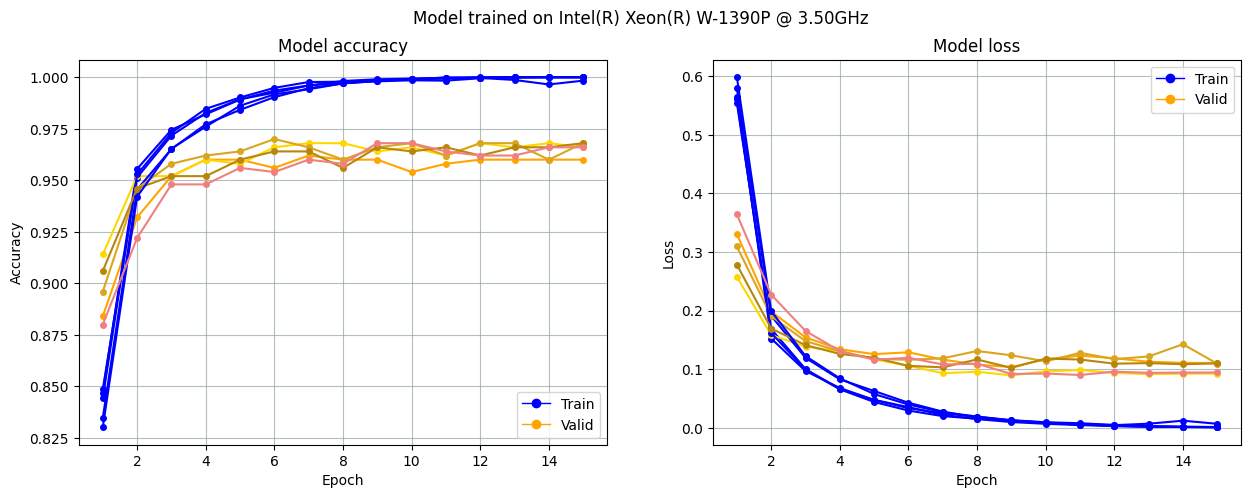

In [28]:
H, t0  = [], time()
print('Trainning', end='')

for i in range(5):
    print(f' #{i+1}', end='')
    
    # Build a new model at each lopp lap, without setting the tf seed:
    model = build_CNN(IM_SHAPE, seed=None)
        
    hist = model.fit(x_train, y_train, # images, labels
                     epochs=15,        # the total number of successive trainings
                     batch_size=32,    # fragmentation of the whole dada set in batches
                     validation_data=(x_valid, y_valid), 
                     verbose=0)
    H.append(hist)  
    
print(f' Total Train {elapsed_time_since(t0)}')    
plot_loss_accuracy(H)   

We can see on these curves that the `valid` train & loss are not reproducible.

### Running several identical training with seed set and tensorflow ops determinism on

Now we will try the same training but with setting the SEDD

Using: "tf.keras.utils.set_random_seed(1234)" and "tf.config.experimental.enable_op_determinism()"
to ensure training reproducibility

Trainning #1 #2 #3 #4 #5 Total Train Elapsed time 36s -> 00:00:36


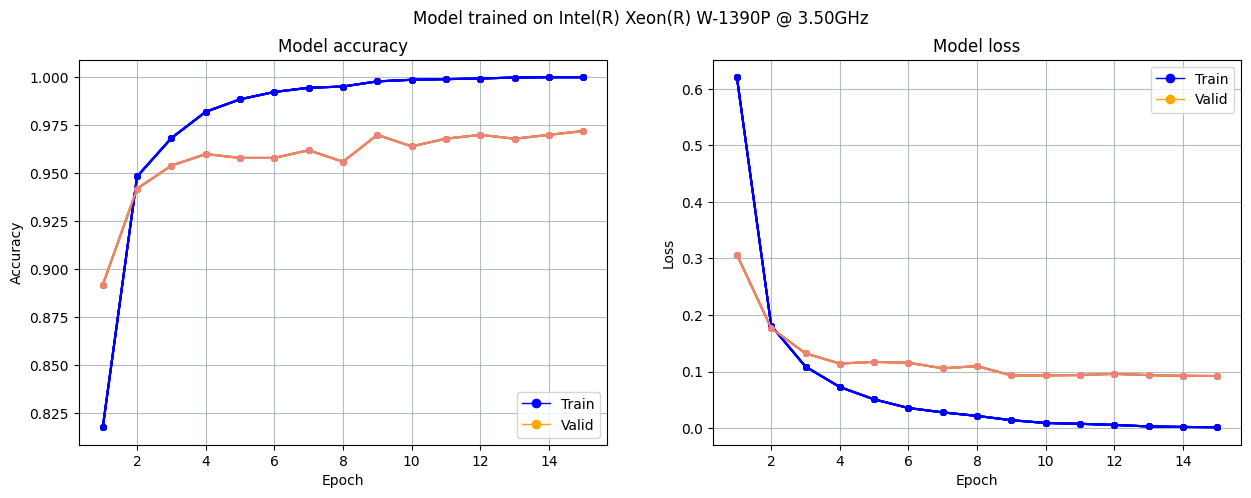

In [29]:
print(f'Using: "tf.keras.utils.set_random_seed({SEED})" and "tf.config.experimental.enable_op_determinism()"\nto ensure training reproducibility\n')

H, t0  = [], time()
print('Trainning', end='')

for i in range(5):
    print(f' #{i+1}', end='')
    
    # Build a new model at each lopp lap, with setting the tf seed:
    model = build_CNN(IM_SHAPE, seed=SEED)
        
    hist = model.fit(x_train, y_train, # images, labels
                     epochs=15,        # the total number of successive trainings
                     batch_size=32,    # fragmentation of the whole dada set in batches
                     validation_data=(x_valid, y_valid), 
                     verbose=0)
    H.append(hist)  
    
print(f' Total Train {elapsed_time_since(t0)}')    
plot_loss_accuracy(H)   

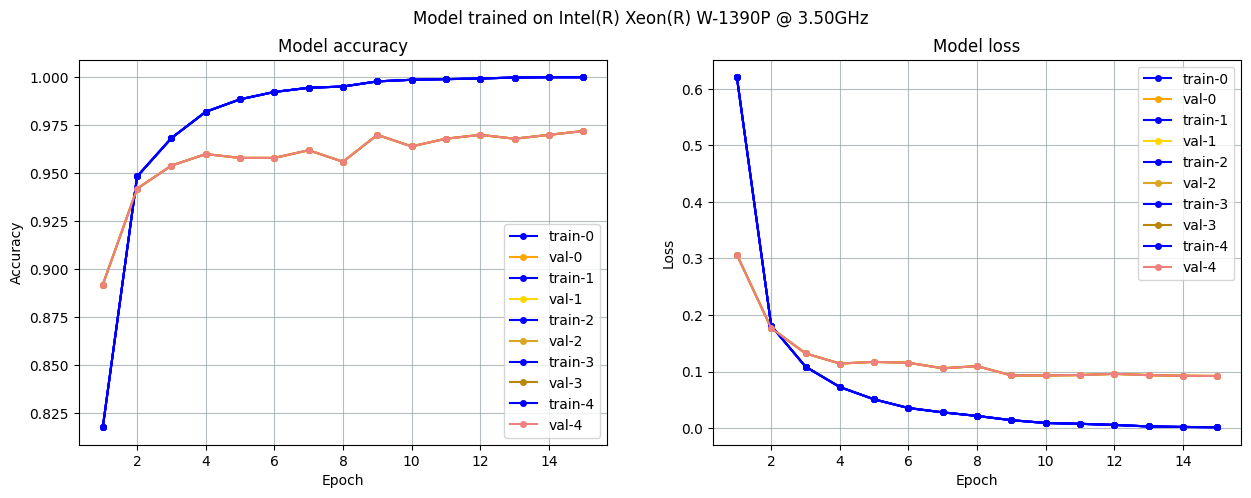

In [30]:
plot_loss_accuracy(H, single_legend=False)  

In the previous cells, we can see that all the learning curves are now perfectly superimposable.<br>
The reproducibility of the training is established.

Let's test the trained model with the __test__ dataset:

In [31]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)

# Predicting labels for test images
predict_labels = np.argmax(model.predict(x_test), axis=-1)

# Display classification report
print("Classification Report:\n", classification_report(np.argmax(y_test, axis=-1), predict_labels))

16/16 - 0s - 3ms/step - accuracy: 0.9840 - loss: 0.0717
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99        43
           1       1.00      0.98      0.99        63
           2       0.97      0.97      0.97        58
           3       1.00      1.00      1.00        53
           4       1.00      0.95      0.97        55
           5       1.00      1.00      1.00        43
           6       1.00      0.98      0.99        44
           7       0.96      1.00      0.98        50
           8       0.98      0.98      0.98        44
           9       0.96      1.00      0.98        47

    accuracy                           0.98       500
   macro avg       0.98      0.98      0.98       500
weighted avg       0.98      0.98      0.98       500



We can now display the __confusion matrix__:

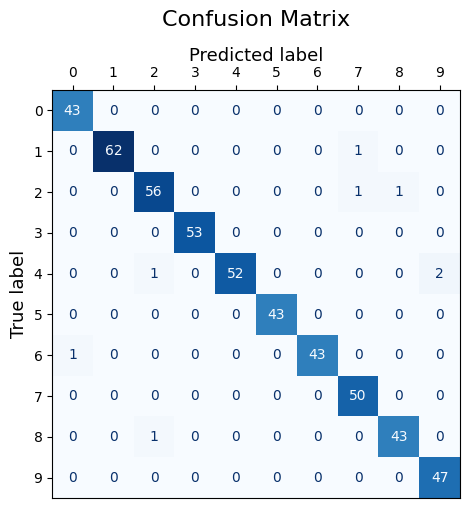

In [32]:
show_conf_matrix(lab_test, predict_labels, range(NB_CLASS), figsize=(7,6))

### Running several identical training with reloading the initial state

Another way to ensure reproductibility is to reload the model structure and initial weights at each run:

Trainning #1

/home/jlc/work/IA-MachineLearning/16-Limoges-IRCEFR/Studies/Reproductibility-MNIST-CNN-GPU/.venv/lib/python3.12/site-packages/keras/src/trainers/trainer.py:212: UserWarning: Model doesn't support `jit_compile=True`. Proceeding with `jit_compile=False`.
  warnings.warn(
/home/jlc/work/IA-MachineLearning/16-Limoges-IRCEFR/Studies/Reproductibility-MNIST-CNN-GPU/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 22 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


 #2 #3 #4 #5 Total Train Elapsed time 6s -> 00:00:06


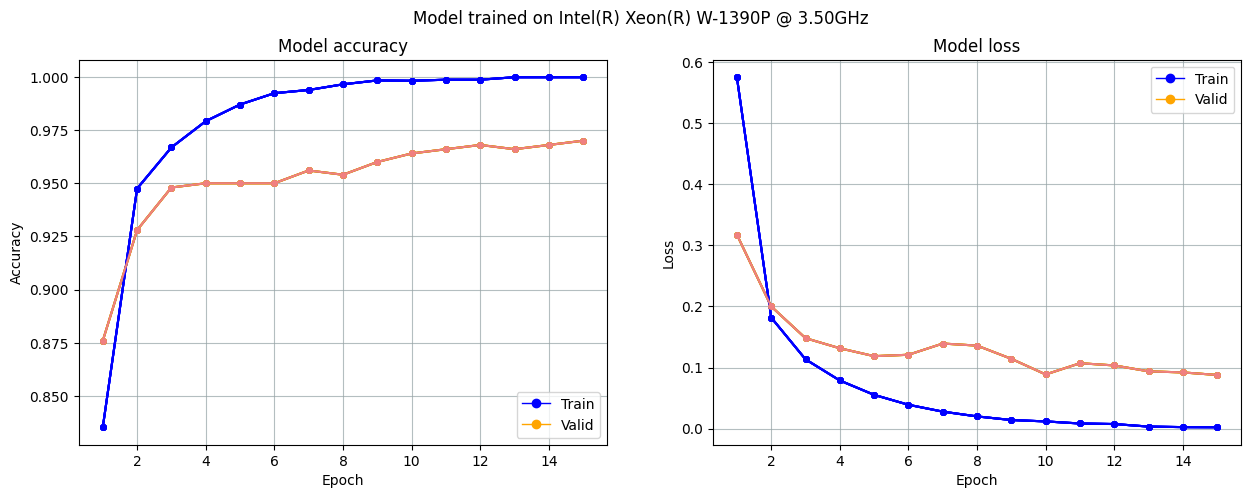

In [33]:
# Deterministic tensorflow training: 
# 1/ set the seed of the random generators involved with tensorflow:
tf.keras.utils.set_random_seed(SEED)
# 2/ make the tf aps determinisctic 
# [see https://blog.tensorflow.org/2022/05/whats-new-in-tensorflow-29.html]
tf.config.experimental.enable_op_determinism()        

H, t0  = [], time()
print('Trainning', end='')

# the structure and the initial waights of the CNN to be used:
model_file = 'CNN_tanh_noseed.keras'

for i in range(5):
    print(f' #{i+1}', end='')
    
    # load the network structure & initial weights:
    model = tf.keras.models.load_model('models/' + model_file)
        
    t0 = time()
    hist = model.fit(x_train, y_train, # images, labels
                     epochs=15,        # the total number of successive trainings
                     batch_size=32,    # fragmentation of the whole dada set in batches
                     validation_data=(x_valid, y_valid), 
                     verbose=0)
    H.append(hist)  
    
print(f' Total Train {elapsed_time_since(t0)}')    
plot_loss_accuracy(H)   

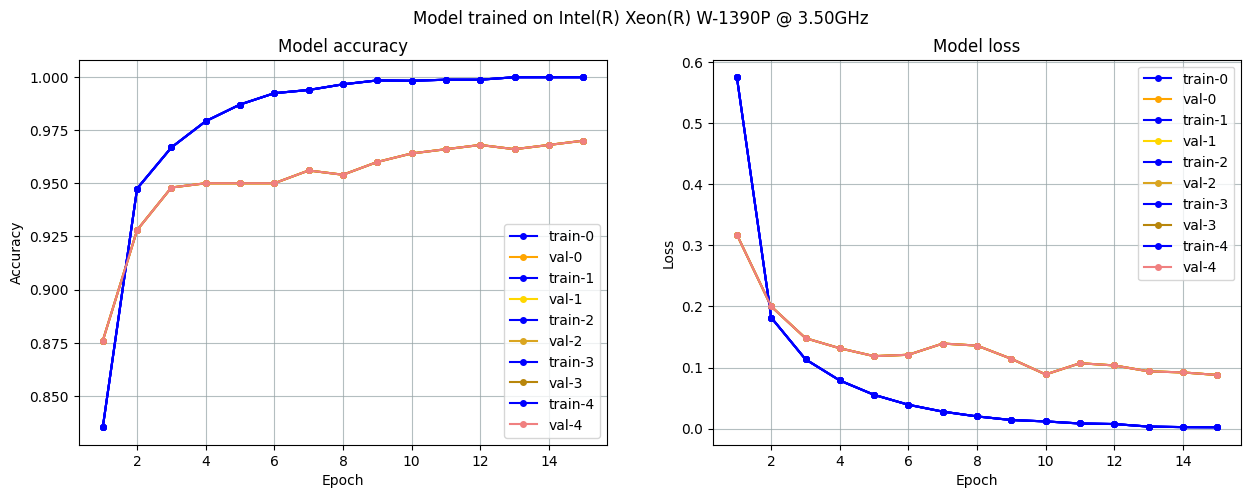

In [34]:
plot_loss_accuracy(H, single_legend=False)  

In the previous cells, we see again that all curves are perfectly superimposable.<br>
The reproducibility of the training is established.

Let's test the trained model with the __test__ dataset:

In [35]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)

# Predicting labels for test images
predict_labels = np.argmax(model.predict(x_test), axis=-1)

# Display classification report
print("Classification Report:\n", classification_report(np.argmax(y_test, axis=-1), predict_labels))

16/16 - 0s - 3ms/step - accuracy: 0.9700 - loss: 0.0804
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98        43
           1       0.98      0.98      0.98        63
           2       0.96      0.95      0.96        58
           3       1.00      0.98      0.99        53
           4       0.96      0.95      0.95        55
           5       1.00      1.00      1.00        43
           6       0.98      0.98      0.98        44
           7       0.98      0.96      0.97        50
           8       0.95      0.93      0.94        44
           9       0.92      0.98      0.95        47

    accuracy                           0.97       500
   macro avg       0.97      0.97      0.97       500
weighted avg       0.97      0.97      0.97       500



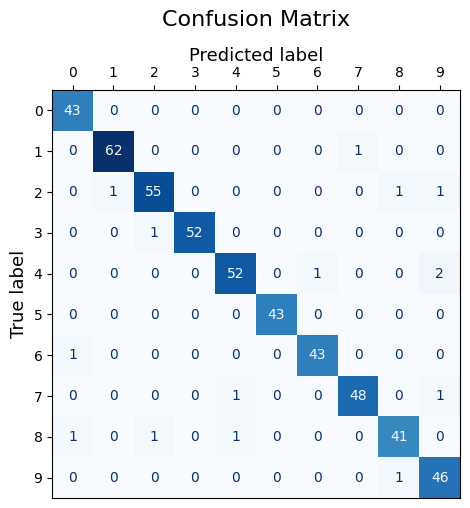

In [36]:
show_conf_matrix(lab_test, predict_labels, range(NB_CLASS), figsize=(7,6))

## 6 - Autres ressources intéressantes... des vidéos :

In [37]:
%%HTML
<iframe src="https://www.youtube.com/embed/trWrEWfhTVg" width="800" height="450" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

In [38]:
%%HTML
<iframe src="https://www.youtube.com/embed/aircAruvnKk" width="800" height="450" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

In [39]:
%%HTML
<iframe src="https://www.youtube.com/embed/IHZwWFHWa-w" width="800" height="450" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

In [40]:
%%HTML
<iframe src="https://www.youtube.com/embed/Ilg3gGewQ5U" width="800" height="450" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>